In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import sys
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})

In [2]:
nTurn = 10000
npt = 9

nCore_y = 1
nCore_z = 1

NL_c = 0.01
NL_t = 0.4
NL_nu= 0.3
NL_L = 1.8
dTune = 0.0

alfx = np.tan(np.pi*NL_nu)
betx = NL_L/np.sin(2.0*np.pi*NL_nu)

# 1. Preparation

In [3]:
beam, lattice = impact.readInputFile('test_toymodel.in');
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.distribution_type = 'ReadFile'
beam.current = 0.0

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

reading ImpactZ input file (test_toymodel.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
def normalize(data):
    data[:,1] = (data[:,0]*alfx/np.sqrt(betx) + data[:,1]*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx/np.sqrt(betx) + data[:,3]*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    
def unnormalize(data):
    data[:,1] = (-data[:,0]*alfx + data[:,1])*NL_c/np.sqrt(betx)
    data[:,3] = (-data[:,2]*alfx + data[:,3])*NL_c/np.sqrt(betx)
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c

In [5]:
for i in range(len(lattice)-1,0,-1):
    if lattice[i].type == 'write_raw_ptcl':
        lattice.pop(i)
lattice[1].n_sckick = 101
lattice[1].n_map = 100
lattice[1].length = NL_L
lattice[1].strength_t = NL_t
lattice[1].transverse_scale_c = NL_c
lattice[1].tune_advance = NL_nu

lattice[2].tune_advance = dTune
lattice[2].nonlinear_insert_tuneAdvance = NL_nu
lattice[2].nonlinear_insert_length = NL_L

In [6]:
lattice[1]


             length: 1.8 [m]
           n_sckick: 101 [1]
              n_map: 100 [1]
         strength_t: 0.4
 transverse_scale_c: 0.01
        pipe_radius: 10.0 [m]
       tune_advance: 0.3
               type: 'nonlinear_insert'

In [7]:
lattice[0].turns = nTurn

TBT = impact.getElem('TBT')
TBT.file_id = 5555
TBT.pID_begin = 1
TBT.pID_end = npt
lattice.insert(1,TBT)

# prepare particles

In [8]:
data=np.loadtxt('arc_points.data')
print(data)
print(data.shape)

[[3.28E-01 3.44E-03]
 [3.40E-01 1.22E-01]
 [3.70E-01 2.25E-01]
 [4.00E-01 2.93E-01]
 [4.50E-01 3.78E-01]
 [5.00E-01 4.44E-01]
 [5.50E-01 4.99E-01]
 [6.00E-01 5.46E-01]
 [6.50E-01 5.85E-01]
 [7.01E-01 6.20E-01]
 [7.50E-01 6.50E-01]
 [8.02E-01 6.77E-01]
 [8.52E-01 6.99E-01]
 [9.02E-01 7.19E-01]
 [9.51E-01 7.35E-01]
 [1.00E+00 7.49E-01]
 [1.05E+00 7.60E-01]
 [1.10E+00 7.70E-01]]
(18, 2)


In [9]:
k=0
q_m = beam.multi_charge.q_m[0]
pTest = np.zeros([npt,9])
pTest[:,6] = q_m
pTest[:,-1] = np.arange(1,npt+1)
x0 =0.450148016509940
y0 = 0.377955996499910
pTest[:,0] = x0 + np.linspace(-1.0e-3,1.0e-3,npt)
pTest[:,2] = y0
# pTest[:,0] = data[:,0]
# pTest[:,2] = data[:,1]
beam.n_particles = npt
unnormalize(pTest)

In [10]:
impact.writeParticleData(pTest, ke, mass, freq)
impact.writeInputFile(beam,lattice) 
impact.run(beam)

0

In [11]:
iTBT,TBT = impact.readTBT(5555,ke,mass,freq)
print(len(iTBT))
print(TBT.shape)

9
(10000, 6, 9)


In [12]:
X = np.zeros([nTurn,npt],dtype=np.complex64)
Y = np.zeros([nTurn,npt],dtype=np.complex64)
for i in range(nTurn):
    X[i,:] = (TBT[i,0,:] - 1j*(betx*TBT[i,1,:]+alfx*TBT[i,0,:]))/(NL_c*np.sqrt(betx))
    Y[i,:] = (TBT[i,2,:] - 1j*(betx*TBT[i,3,:]+alfx*TBT[i,2,:]))/(NL_c*np.sqrt(betx))

In [13]:
tuneX = np.zeros(npt)
tuneY = np.zeros(npt)
for i in range(npt):
    signal = X[:,i] - X[:,i].mean()
    tuneX[i], amp, dummy = impact.util.naff(1,signal)
    signal = Y[:,i] - Y[:,i].mean()
    tuneY[i], amp, dummy = impact.util.naff(1,signal)

In [14]:
# plt.figure(figsize=(12,3))
# plt.subplot(1,3,1)
# plt.plot(np.real(X[0,:]),tuneX/0.3,'*-')
# plt.xlabel('$x_n$');
# plt.ylabel(r'$\omega_x$');
# plt.subplot(1,3,2)
# plt.plot(np.real(X[0,:]),tuneY/0.3,'*-')
# plt.xlabel('$x_n$');
# plt.ylabel(r'$\omega_y$');
# plt.subplot(1,3,3)
# plt.plot(np.real(X[0,:]),tuneY/tuneX,'*-')
# plt.xlabel('$x_n$');
# plt.ylabel(r'$\omega_y/\omega_x$');
# plt.tight_layout()
# plt.savefig('tune.onArc.png',dpi=180)

# Case 1

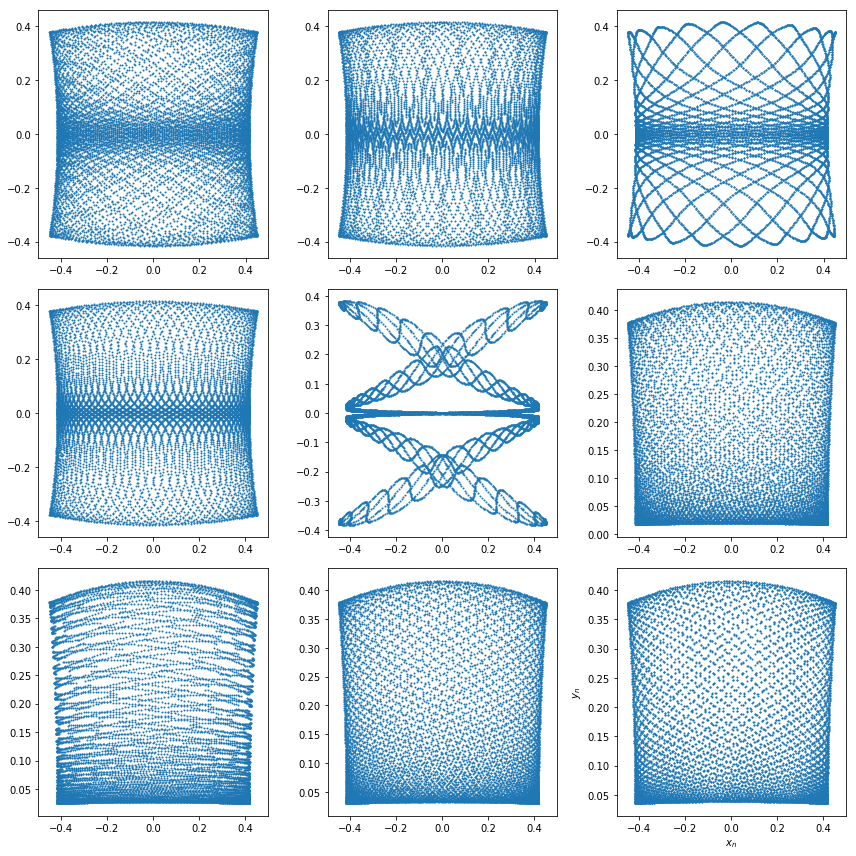

In [15]:
plt.figure(figsize=(12,12))
for i in range(3):
    for j in range(3):
        plt.subplot(3,3,3*i+j+1)
        plt.scatter(np.real(X[:,3*i+j]),np.real(Y[:,3*i+j]),s=1.0)
plt.xlabel('$x_n$');
plt.ylabel('$y_n$');
plt.tight_layout()

# Case 2

In [16]:
k=0
q_m = beam.multi_charge.q_m[0]
pTest = np.zeros([npt,9])
pTest[:,6] = q_m
pTest[:,-1] = np.arange(1,npt+1)
x0 =0.450148016509940
y0 = 0.377955996499910
pTest[:,0] = x0 + np.linspace(-1.0e-4,1.0e-4,npt)
pTest[:,2] = y0
# pTest[:,0] = data[:,0]
# pTest[:,2] = data[:,1]
beam.n_particles = npt
unnormalize(pTest)

In [17]:
impact.writeParticleData(pTest, ke, mass, freq)
impact.writeInputFile(beam,lattice) 
impact.run(beam)

0

In [18]:
iTBT,TBT = impact.readTBT(5555,ke,mass,freq)
print(len(iTBT))
print(TBT.shape)

9
(10000, 6, 9)


In [19]:
X = np.zeros([nTurn,npt],dtype=np.complex64)
Y = np.zeros([nTurn,npt],dtype=np.complex64)
for i in range(nTurn):
    X[i,:] = (TBT[i,0,:] - 1j*(betx*TBT[i,1,:]+alfx*TBT[i,0,:]))/(NL_c*np.sqrt(betx))
    Y[i,:] = (TBT[i,2,:] - 1j*(betx*TBT[i,3,:]+alfx*TBT[i,2,:]))/(NL_c*np.sqrt(betx))

In [20]:
tuneX = np.zeros(npt)
tuneY = np.zeros(npt)
for i in range(npt):
    signal = X[:,i] - X[:,i].mean()
    tuneX[i], amp, dummy = impact.util.naff(1,signal)
    signal = Y[:,i] - Y[:,i].mean()
    tuneY[i], amp, dummy = impact.util.naff(1,signal)

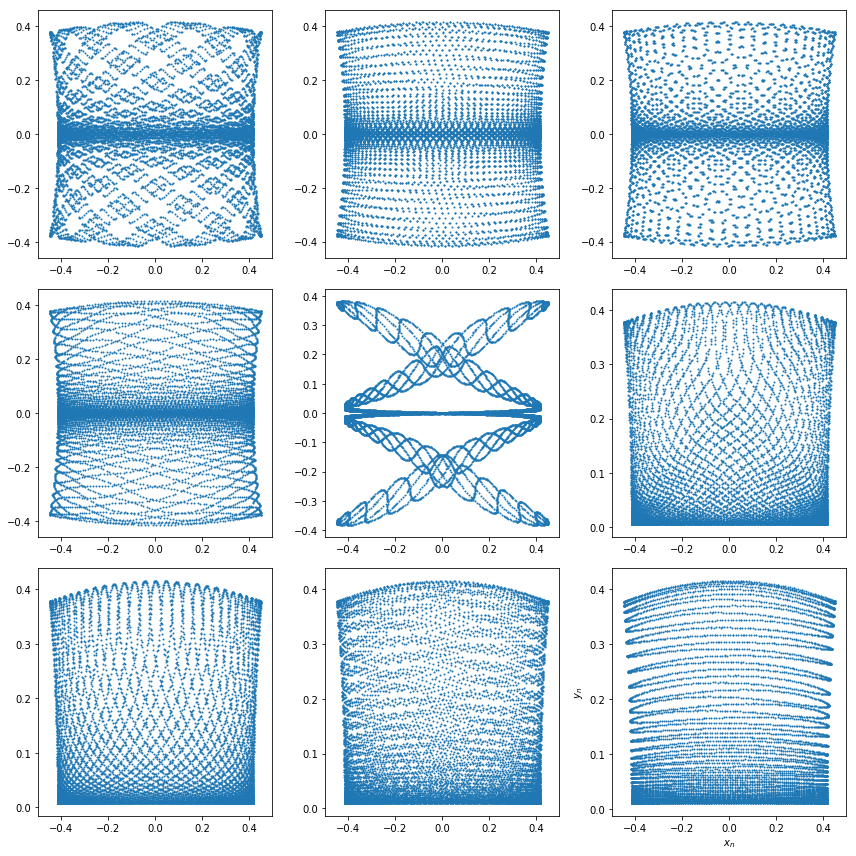

In [21]:
plt.figure(figsize=(12,12))
for i in range(3):
    for j in range(3):
        plt.subplot(3,3,3*i+j+1)
        plt.scatter(np.real(X[:,3*i+j]),np.real(Y[:,3*i+j]),s=1.0)
plt.xlabel('$x_n$');
plt.ylabel('$y_n$');
plt.tight_layout()

# Case 3

In [22]:
k=0
q_m = beam.multi_charge.q_m[0]
pTest = np.zeros([npt,9])
pTest[:,6] = q_m
pTest[:,-1] = np.arange(1,npt+1)
x0 =0.450148016509940
y0 = 0.377955996499910
pTest[:,0] = x0 + np.linspace(-1.0e-5,1.0e-5,npt)
pTest[:,2] = y0
# pTest[:,0] = data[:,0]
# pTest[:,2] = data[:,1]
beam.n_particles = npt
unnormalize(pTest)

In [23]:
impact.writeParticleData(pTest, ke, mass, freq)
impact.writeInputFile(beam,lattice) 
impact.run(beam)

0

In [24]:
iTBT,TBT = impact.readTBT(5555,ke,mass,freq)
print(len(iTBT))
print(TBT.shape)

9
(10000, 6, 9)


In [25]:
X = np.zeros([nTurn,npt],dtype=np.complex64)
Y = np.zeros([nTurn,npt],dtype=np.complex64)
for i in range(nTurn):
    X[i,:] = (TBT[i,0,:] - 1j*(betx*TBT[i,1,:]+alfx*TBT[i,0,:]))/(NL_c*np.sqrt(betx))
    Y[i,:] = (TBT[i,2,:] - 1j*(betx*TBT[i,3,:]+alfx*TBT[i,2,:]))/(NL_c*np.sqrt(betx))

In [26]:
tuneX = np.zeros(npt)
tuneY = np.zeros(npt)
for i in range(npt):
    signal = X[:,i] - X[:,i].mean()
    tuneX[i], amp, dummy = impact.util.naff(1,signal)
    signal = Y[:,i] - Y[:,i].mean()
    tuneY[i], amp, dummy = impact.util.naff(1,signal)

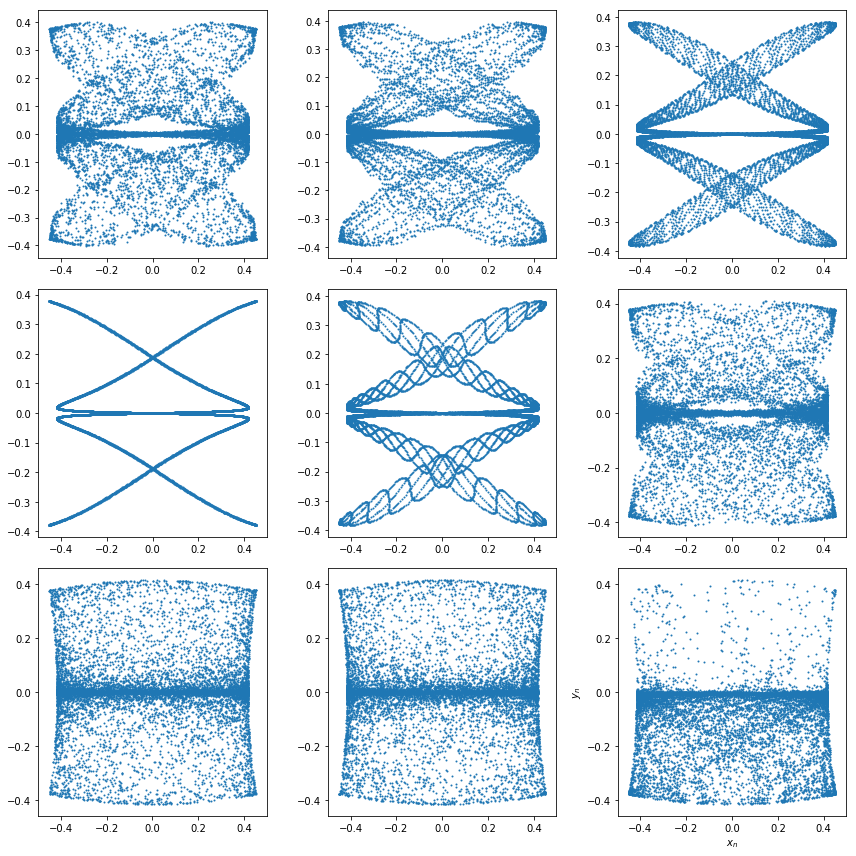

In [27]:
plt.figure(figsize=(12,12))
for i in range(3):
    for j in range(3):
        plt.subplot(3,3,3*i+j+1)
        plt.scatter(np.real(X[:,3*i+j]),np.real(Y[:,3*i+j]),s=1.0)
plt.xlabel('$x_n$');
plt.ylabel('$y_n$');
plt.tight_layout()

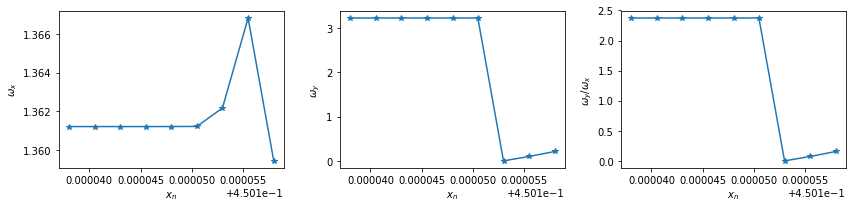

In [28]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(np.real(X[0,:]),tuneX/0.3,'*-')
plt.xlabel('$x_n$');
plt.ylabel(r'$\omega_x$');
plt.subplot(1,3,2)
plt.plot(np.real(X[0,:]),tuneY/0.3,'*-')
plt.xlabel('$x_n$');
plt.ylabel(r'$\omega_y$');
plt.subplot(1,3,3)
plt.plot(np.real(X[0,:]),tuneY/tuneX,'*-')
plt.xlabel('$x_n$');
plt.ylabel(r'$\omega_y/\omega_x$');
plt.xlim((np.real(X[0,:]).min(),np.real(X[0,:]).max()))
plt.tight_layout()
# plt.savefig('tune.onArc.png',dpi=180)

# Case 4

In [35]:
k=0
q_m = beam.multi_charge.q_m[0]
pTest = np.zeros([npt,9])
pTest[:,6] = q_m
pTest[:,-1] = np.arange(1,npt+1)
x0 =0.450148016509940
y0 = 0.377955996499910
pTest[:,0] = x0 + np.linspace(-4.0e-5,4.0e-5,npt)
pTest[:,2] = y0
# pTest[:,0] = data[:,0]
# pTest[:,2] = data[:,1]
beam.n_particles = npt
unnormalize(pTest)

In [42]:
np.linspace(-4.0e-5,4.0e-5,npt)

array([-4.00E-05, -3.00E-05, -2.00E-05, -1.00E-05, 0.00E+00, 1.00E-05,
       2.00E-05, 3.00E-05, 4.00E-05])

In [36]:
impact.writeParticleData(pTest, ke, mass, freq)
impact.writeInputFile(beam,lattice) 
impact.run(beam)

0

In [37]:
iTBT,TBT = impact.readTBT(5555,ke,mass,freq)
print(len(iTBT))
print(TBT.shape)

9
(10000, 6, 9)


In [38]:
X = np.zeros([nTurn,npt],dtype=np.complex64)
Y = np.zeros([nTurn,npt],dtype=np.complex64)
for i in range(nTurn):
    X[i,:] = (TBT[i,0,:] - 1j*(betx*TBT[i,1,:]+alfx*TBT[i,0,:]))/(NL_c*np.sqrt(betx))
    Y[i,:] = (TBT[i,2,:] - 1j*(betx*TBT[i,3,:]+alfx*TBT[i,2,:]))/(NL_c*np.sqrt(betx))

In [39]:
tuneX = np.zeros(npt)
tuneY = np.zeros(npt)
for i in range(npt):
    signal = X[:,i] - X[:,i].mean()
    tuneX[i], amp, dummy = impact.util.naff(1,signal)
    signal = Y[:,i] - Y[:,i].mean()
    tuneY[i], amp, dummy = impact.util.naff(1,signal)

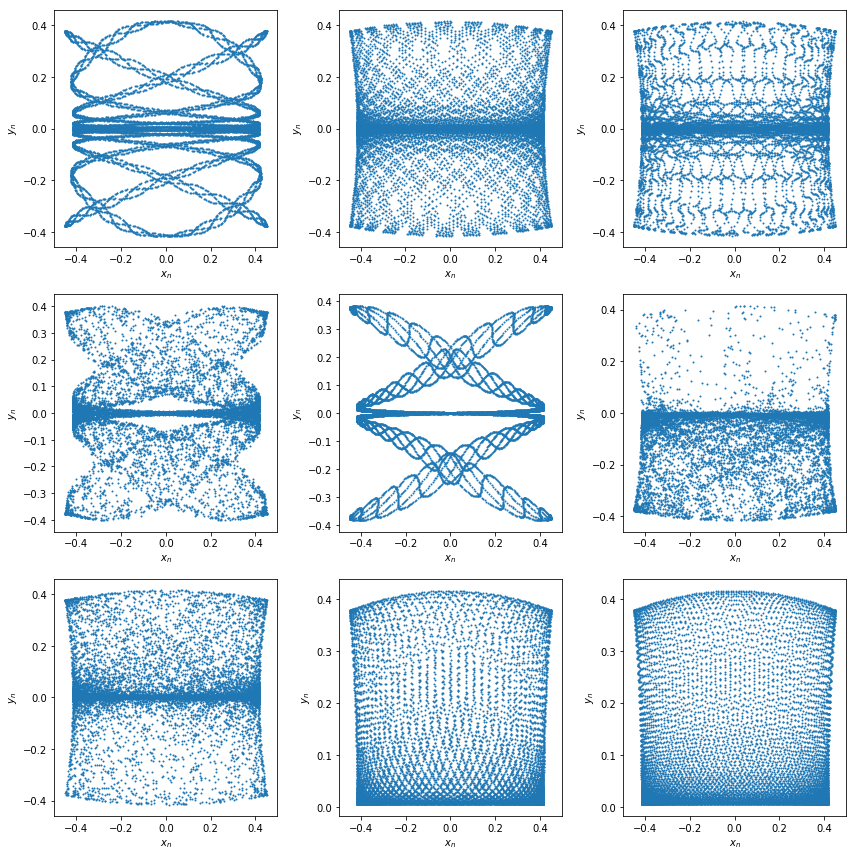

In [43]:
plt.figure(figsize=(12,12))
for i in range(3):
    for j in range(3):
        plt.subplot(3,3,3*i+j+1)
        plt.scatter(np.real(X[:,3*i+j]),np.real(Y[:,3*i+j]),s=1.0)
        plt.xlabel('$x_n$');
        plt.ylabel('$y_n$');
plt.tight_layout()

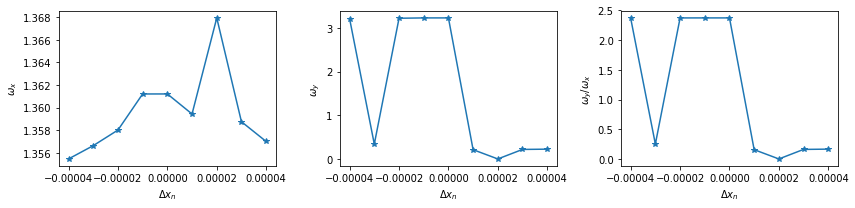

In [46]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(np.real(X[0,:]-x0),tuneX/0.3,'*-')
plt.xlabel('$\Delta x_n$');
plt.ylabel(r'$\omega_x$');
plt.subplot(1,3,2)
plt.plot(np.real(X[0,:]-x0),tuneY/0.3,'*-')
plt.xlabel('$\Delta x_n$');
plt.ylabel(r'$\omega_y$');
plt.subplot(1,3,3)
plt.plot(np.real(X[0,:]-x0),tuneY/tuneX,'*-')
plt.xlabel('$\Delta x_n$');
plt.ylabel(r'$\omega_y/\omega_x$');
plt.tight_layout()
# plt.savefig('tune.onArc.png',dpi=180)